# **Global Defines**

In [ ]:
T_G_WIDTH = 224
T_G_HEIGHT = 224
T_G_NUMCHANNELS = 3
T_G_SEED = 1337

# **Imports**

In [2]:
#Torch Imports
import torch
import torchvision
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.transforms import ToPILImage

import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#analytics
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

#Misc.
import random
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

# **Preprocessing & Augmentation**

In [ ]:
face_dataset_path = './Dataset/AFDB_face_dataset'
masked_face_dataset_path = './Dataset/AFDB_masked_face_dataset'
masked_face_dataset_2_path = './AFDB_face_dataset_masked'
model_Path = F'/content/drive/MyDrive/FR_Model'
save_path = os.path.join(model_Path, 'model.pth')

In [ ]:
np.random.seed(T_G_SEED)
torch.manual_seed(T_G_SEED)
random.seed(T_G_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mean = [0.4363, 0.4328, 0.3291]
std= [0.2129, 0.2075, 0.2038]

#Change mean and STD later
data_transforms = {
    'train': transforms.Compose([
                                #transforms.ToPILImage(),
                                transforms.Resize((224, 224)),
                                #transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomVerticalFlip(p=0.05),
                                #transforms.ColorJitter(brightness=0.5),
                                transforms.ToTensor(),
                                #transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                               ]),
                   
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
!unzip "drive/MyDrive/Dataset/Dataset.zip"
!unzip "drive/MyDrive/Dataset/Masked.zip"

In [ ]:
face_dataset = torchvision.datasets.ImageFolder(face_dataset_path, transform = data_transforms['train'])
masked_dataset = torchvision.datasets.ImageFolder(masked_face_dataset_path, transform = data_transforms['train'])

In [ ]:
def get_train_and_test_set(face_dataset):
  train_size = int(0.8 * len(face_dataset))
  test_size = len(face_dataset) - train_size

  train_dataset, test_dataset = torch.utils.data.random_split(face_dataset, [train_size, test_size])
  return train_dataset, test_dataset

In [ ]:
def get_loader(dataset):
    #create a loader
    loader = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle = True)  
    
    return loader

In [ ]:
train_dataset, test_dataset = get_train_and_test_set(face_dataset)  #gets the training and testing datasets

In [ ]:
train_loader = get_loader(train_dataset) #gets a training loader

# **Triplet Loss**

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    #Sum of difference of Square Roots (Norm Distance)
    def calc_euclidean(self, x1, x2):
        return(x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive) #1
        distance_negative_a = self.calc_euclidean(anchor, negative) #2
        distance_negative_b = self.calc_euclidean(positive, negative) #4
                                #  1 - ((2 + 4)/2) + 1 = relu(max(-3,0))
        losses = torch.relu(distance_positive - (distance_negative_a + distance_negative_b)/2.0 + self.margin)

        return losses.mean()

# **ResNet50Model**

In [ ]:
class MaskedFaceNetResNet50(nn.Module):
  def __init__(self):
      super(MaskedFaceNetResNet50,self).__init__()
      self.backbone = models.resnet50(pretrained=False)
      
      # Remove AveragePool and FC layers
      self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
      #model.classifier = nn.Sequential(*[model.classifier[i] for i in range(4)])
      
      # embedding size 512 or 128
      output_dim = 512
      self.output_layer = Sequential(Dropout(0.6),
                                      AdaptiveAvgPool2d(output_size=(1, 1)),
                                      Flatten(),
                                      Linear(in_features=2048, out_features=output_dim, bias=True),
                                      BatchNorm1d(output_dim))

  def forward(self,x):
      x = self.backbone(x)
      x = self.output_layer(x)
      #x = F.normalize(x, p=2, dim=1)
      x = l2_norm(x)
      return x

# **ResNet18Model**

In [ ]:
# Control fine-tuning of backbone
def set_parameter_requires_grad(model, feature_extracting):
    if (feature_extracting):
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Define the network. Use a ResNet18 backbone. Redefine the last layer,
# replacing the classification layer with an embeding layer. In the
# current implementation, parameters for the base model are frozen by default.
class EmbeddingNetwork(nn.Module):
    def __init__(self, emb_dim = 128, is_pretrained=False, freeze_params=True):
        super(EmbeddingNetwork, self).__init__()

        self.backbone = models.resnet18(pretrained=is_pretrained)
        set_parameter_requires_grad(self.backbone, freeze_params)

        # replace the last classification layer with an embedding layer.
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, emb_dim)

        # make that layer trainable
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

        self.inputsize = T_G_WIDTH

    def forward(self, x):

        x = self.backbone(x)
        x = F.normalize(x, p=2.0, dim=1)

        return x

# **Model**

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
def create_model():
  # load model
  model = torchvision.models.resnet50(pretrained = False, progress = True)

  in_ftr  = model.fc.in_features
  out_ftr = 460
  model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
  model = model.to('cuda')
  return model

In [ ]:
def save_checkpoint(model, optimizer, save_path, epoch):
  
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'epoch': epoch,
      'loss': loss
  }, save_path)

In [ ]:
def load_checkpoint(model, optimizer, load_path):

  checkpoint = torch.load(save_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  #Optimizer typo
  optimizer.load_state_dict(checkpoint['optimzier_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  
  return model, optimizer, epoch, loss

In [ ]:
model = create_model()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5

In [1]:
def create_embedding_model():

  model = EmbeddingNetwork(emb_dim=128, freeze_params=False)
  device = "cuda"
  model = model.to(device)
  optimizer = torch.optim.Adadelta(model.parameters())
  criterion = TripletLoss(margin=1.0)

In [ ]:
model, optimizer, epoch, loss = load_checkpoint(model, optimizer, save_path)

# **TripletLoader**

In [ ]:
# Define the DataSet object to load the data from folders.
# Inherit from the PyTorch ImageFolder class, which gets us close to
# what we need. Necessary changes are to create an inverse look-up table
# based on labels. Given a label, find another random image with that
# same label, and also take a random image from a random other different 
# category for a negative instance, giving us the triplet: 
# [anchor, positive, negative].
class TripletFolder(ImageFolder):
    def __init__(self, root: str, transform: Optional[Callable] = None):
        super(TripletFolder, self).__init__(root=root, transform=transform)

        # Create a dictionary of lists for each class for reverse lookup
        # to generate triplets 
        self.classdict = {}
        for c in self.classes:
            ci = self.class_to_idx[c]
            self.classdict[ci] = []

        # append each file in the approach dictionary element list
        for s in self.samples:
            self.classdict[s[1]].append(s[0])

        # keep track of the sizes for random sampling
        self.classdictsize = {}
        for c in self.classes:
            ci = self.class_to_idx[c]
            self.classdictsize[ci] = len(self.classdict[ci])

    # Return a triplet, with positive and negative selected at random.
    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, sample, sample) where the samples are anchor, positive, and negative.
            The positive and negative instances are sampled randomly. 
        """

        # The anchor is the image at this index.
        #a_path = image_path , a_target = label()
        a_path, a_target = self.samples[index]

        prs = random.random() # positive random sample
        nrc = random.random() # negative random class
        nrs = random.random() # negative random sample

        # random negative class cannot be the same class as anchor. We add
        # a random offset that is 1 less than the number required to wrap
        # back around to a_target after modulus. 
        nrc = (a_target + int(nrc*(len(self.classes) - 1))) % len(self.classes)

        # Positive Instance: select a random instance from the same class as anchor.
        # el path beta3 el positive image hyb2a el label beta3 el class fi kam soora 
        # wel 3uddud dugh yederreb fih (0-1) 3shan mutetlu3sh brra el range.  
        p_path = self.classdict[a_target][int(self.classdictsize[a_target]*prs)]
        
        # Negative Instance: select a random instance from the random negative class.
        n_path = self.classdict[nrc][int(self.classdictsize[nrc]*nrs)]

        # Load the data for these samples.
        a_sample = self.loader(a_path)
        p_sample = self.loader(p_path)
        n_sample = self.loader(n_path)

        # apply transforms
        if self.transform is not None:
            a_sample = self.transform(a_sample)
            p_sample = self.transform(p_sample)
            n_sample = self.transform(n_sample)

        # note that we do not return the label! 
        return a_sample, p_sample, n_sample

In [ ]:
test_ds_masked = TripletFolder(root=masked_face_dataset_path, transform=data_transforms['train'])

In [ ]:
test_ds_masked.classdict

In [ ]:
test_ds_masked.samples[30]

('./AFDB_masked_face_dataset/AFDB_masked_face_dataset/chenguanxi/0_0_2.jpg',
 21)

In [ ]:
test_loader = DataLoader(test_ds_masked, batch_size=5, shuffle=False, num_workers=1)

In [ ]:
for epoch in tqdm(range(1), desc="Epochs"):
  device = "cuda"

  batch = next(iter(test_loader))
  #print("Batch Number: " + str(len(test_loader)))
  anchor_img, positive_img, negative_img = batch

In [ ]:
test_loader.batch_sampler.batch_size

5

In [ ]:
a_sample = test_ds_masked.loader('./AFDB_masked_face_dataset/AFDB_masked_face_dataset/caihancen/1_0_1.jpg')

In [ ]:
test_ds_masked.classdict[8]

['./AFDB_masked_face_dataset/AFDB_masked_face_dataset/caihancen/1_0_1.jpg']

In [ ]:
  #for a in anchor_img:
    #imshow(a.squeeze(dim = 0).permute(1, 2, 0).cpu())

  #for i in range(5):
    #imshow(anchor_img[i].squeeze(dim = 0).permute(1, 2, 0).cpu())

  
  #imshow(negative_img[5].squeeze(dim = 0).permute(1, 2, 0).cpu())

  #imshow(positive_img[0].squeeze(dim = 0).permute(1, 2, 0).cpu())

  #imshow(negative_img[0].squeeze(dim = 0).permute(1, 2, 0).cpu())

# **Training**

In [ ]:
#Training the network
for epoch in epochs:

  print('Epoch: [{}/{}]'.format(epoch+1, epochs))
  model.train()
  
  total_loss = 0
  total_correct = 0

  for batch in train_loader:
      images, labels = batch
      
      images = images.to('cuda')
      labels = labels.to('cuda')

      # pass images into model
      preds = model(images)
      
      # get loss
      loss = F.cross_entropy(preds, labels)

      # set gradients = 0
      optimizer.zero_grad()

      #calculate new gradients
      loss.backward()

      #update weights
      optimizer.step()

      total_loss += loss.item()
      total_correct += get_num_correct(preds, labels)
      
  print("Epoch:", epoch, 'total_correct', total_correct, "total_loss", total_loss)
  save_checkpoint(model, optimizer, save_path, epoch)

NameError: ignored

In [ ]:
accuracy = 100 * total_correct / len(train_dataset)

NameError: ignored

# **New Training**

In [ ]:
# Train the model based on labels from an input folder. 
# Online triplet selection: random selection. 
def learn():

    in_t_folder = face_dataset_path
    emb_size = 128
    batch = 90
    numepochs = 10
    outpath = save_path
    
    margin = 1.0

    device = "cuda" 


    print('Triplet embeding training session. Inputs: ' + in_t_folder + ', ' + str(emb_size) + ', ' + str(batch) + ', ' + str(numepochs) + ', ' + str(margin) + ', ' + outpath)

    face_ds = TripletFolder(root=in_t_folder, transform=data_transforms['train'])

    #face without masks dataset split
    train_ds, test_ds = get_train_and_test_set(face_ds)

    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=1)
    
    # Allow all parameters to be fit
    model = EmbeddingNetwork(emb_dim=emb_size, freeze_params=False)
    
    #model = torch.jit.script(model).to(device) # send model to GPU
    model = model.to(device) # send model to GPU
    
    optimizer = optim.Adadelta(model.parameters()) #optim.Adam(model.parameters(), lr=0.01)
    criterion = TripletLoss(margin=margin)

    model.train()

    # let invalid epochs pass through without training
    if numepochs < 1:
        epoch = 0
        loss = 0

    for epoch in tqdm(range(numepochs), desc="Epochs"):
        running_loss = []
        for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            
            anchor_img = anchor_img.to(device) # send image to GPU
            positive_img = positive_img.to(device) # send image to GPU
            negative_img = negative_img.to(device) # send image to GPU
        
            optimizer.zero_grad()
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)
        
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()
        
            running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, numepochs, np.mean(running_loss)))

    torch.save({
            'emb_size': emb_size,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimzier_state_dict': optimizer.state_dict(),
            'loss': loss
           }, outpath)

    return

In [ ]:
learn()

Triplet embeding training session. Inputs: ./Dataset/AFDB_face_dataset, 128, 90, 10, 1.0, /content/drive/MyDrive/FR_Model/model.pth


Epochs:  10%|█         | 1/10 [24:15<3:38:22, 1455.83s/it]

Epoch: 1/10 - Loss: 0.6141



Epochs:  20%|██        | 2/10 [48:32<3:14:10, 1456.31s/it]

Epoch: 2/10 - Loss: 0.4535



Epochs:  30%|███       | 3/10 [1:12:51<2:50:02, 1457.50s/it]

Epoch: 3/10 - Loss: 0.4136



Epochs:  40%|████      | 4/10 [1:37:14<2:25:59, 1459.91s/it]

Epoch: 4/10 - Loss: 0.3810



Epochs:  50%|█████     | 5/10 [2:01:37<2:01:44, 1460.84s/it]

Epoch: 5/10 - Loss: 0.3548



Training:  29%|██▉       | 234/805 [07:04<17:19,  1.82s/it]

# **Testing**

In [ ]:
val_ds = TripletFolder(root=masked_face_dataset_2_path, transform=data_transforms['train'])

In [ ]:
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
p_sample = val_ds.loader('./AFDB_face_dataset_masked/aidai/1_0_aidai_0033_surgical.jpg')

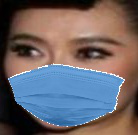

In [ ]:
p_sample

In [ ]:
_, p_sample, _,= next(iter(val_loader))

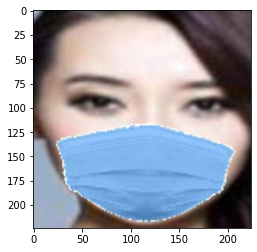

In [ ]:
imshow(p_sample.squeeze(dim = 0).permute(1, 2, 0))

In [ ]:
batch = next(iter(test_loader))

In [ ]:
a, p, n = batch

In [ ]:
imshow(p_sample.squeeze(dim = 0).permute(1, 2, 0))

In [ ]:
def test():

  in_t_folder = masked_face_dataset_path
  emb_size = 128
  batch = 1
  outpath = save_path
  device = "cuda"

  test_ds = TripletFolder(root=in_t_folder, transform=data_transforms['test'])
  test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False, num_workers=1) 

  #testing masked Facial Recognition

  with torch.no_grad():
    model.eval()

  anchor_img, _, _,= next(iter(test_loader))
  anchor_img = anchor_img.to(device) # send image to GPU
  anchor_out = model(anchor_img)
  
  for step, ( _, positive_img, negative_img) in enumerate(tqdm(test_loader, desc="Testing", leave=False)):

    positive_img = positive_img.to(device) # send image to GPU
    negative_img = negative_img.to(device) # send image to GPU

    positive_out = model(positive_img)
    negative_out = model(negative_img)

    #concatenated = torch.cat((anchor_img, positive_img, negative_img), 0)
    #euclidean_distance = F.triplet_margin_with_distance_loss(anchor_out, positive_out, negative_out)

    triplet_loss = F.triplet_margin_with_distance_loss(anchor_out, positive_out, negative_out)

    #imshow(torchvision.utils.make_grid(concatenated[:,0]), 'Accent', f'Dissimilarity: {euclidean_distance.item():.2f}')

    #imshow(concatenated.squeeze(dim = 0).squeeze(dim = 1).permute(1, 2, 0).cpu())

    #move to CPU

    #imshow(anchor_img.squeeze(dim = 0).permute(1, 2, 0).cpu())

    #imshow(positive_img.squeeze(dim = 0).permute(1, 2, 0).cpu())

    #imshow(negative_img.squeeze(dim = 0).permute(1, 2, 0).cpu())

    #anchor_out = F.sigmoid(anchor_out)
    print("Dissimilarity: ", triplet_loss)

    imshow(anchor_img.squeeze(dim = 0).permute(1, 2, 0).cpu())
    break;

Dissimilarity:  tensor(0.6220, device='cuda:0', grad_fn=<MeanBackward0>)


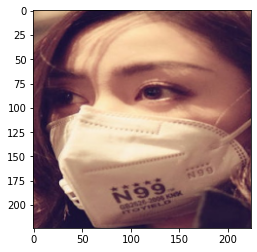

In [ ]:
test()

In [ ]:
test_ds_masked = TripletFolder(root=masked_face_dataset_path, transform=data_transforms['train'])

# *Manual Test*

Dissimilarity:  0.5824192762374878


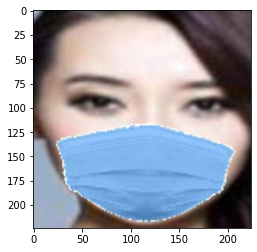

In [ ]:
anchor_img = anchor_img.to(device) # send image to GPU
anchor_out = model(anchor_img)

positive_img = positive_img.to(device) # send image to GPU
negative_img = negative_img.to(device) # send image to GPU
p_sample = p_sample.to(device)

positive_out = model(positive_img)
p_sample_out = model(p_sample)

#concatenated = torch.cat((anchor_img, positive_img, negative_img), 0)
#euclidean_distance = F.triplet_margin_with_distance_loss(anchor_out, positive_out, negative_out)

triplet_loss = F.triplet_margin_with_distance_loss(anchor_out, positive_out, p_sample_out)
print("Dissimilarity: ", triplet_loss.item())

imshow(anchor_img[0].squeeze(dim = 0).permute(1, 2, 0).cpu())

imshow(p_sample.squeeze(dim = 0).permute(1, 2, 0).cpu())